**Project Check-in 1**
1. We chose the Spotify Prediction dataset.
2. We are studying how different aspects of tracks such as loudness, instrumentalness, tempo, and genre individually predict popularity, and how they combine to predict popularity.
3. See below.
4. See below.

In [41]:
%pip install scikit-lego
%pip install seaborn
#%pip install nbstripout
#%nbstripout --install

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


df = pd.read_csv("./dataset.csv")

In [2]:
# Drop all duplicates (need to remove the first column because these are just indices)
revised_df = df.drop(columns='Unnamed: 0').drop_duplicates(subset=['track_id','album_name','artists','track_name'])

In [3]:
# Drop NaN values
# NEED TO FIGURE OUT WHETHER THIS IS WORTH IT BC ONLY ARTISTS/ALBUM_NAME/TRACK_NAME ARE NAN

revised_df.dropna(axis=0,inplace=True)

In [4]:
revised_df.drop(columns=['track_id', 'artists', 'album_name', 'track_name'], inplace=True)
columns = revised_df.columns
le = LabelEncoder()
revised_df['track_genre'] = le.fit_transform(revised_df['track_genre'])

scaler = StandardScaler()
revised_df = scaler.fit_transform(revised_df)
revised_df = pd.DataFrame(revised_df, columns=columns)

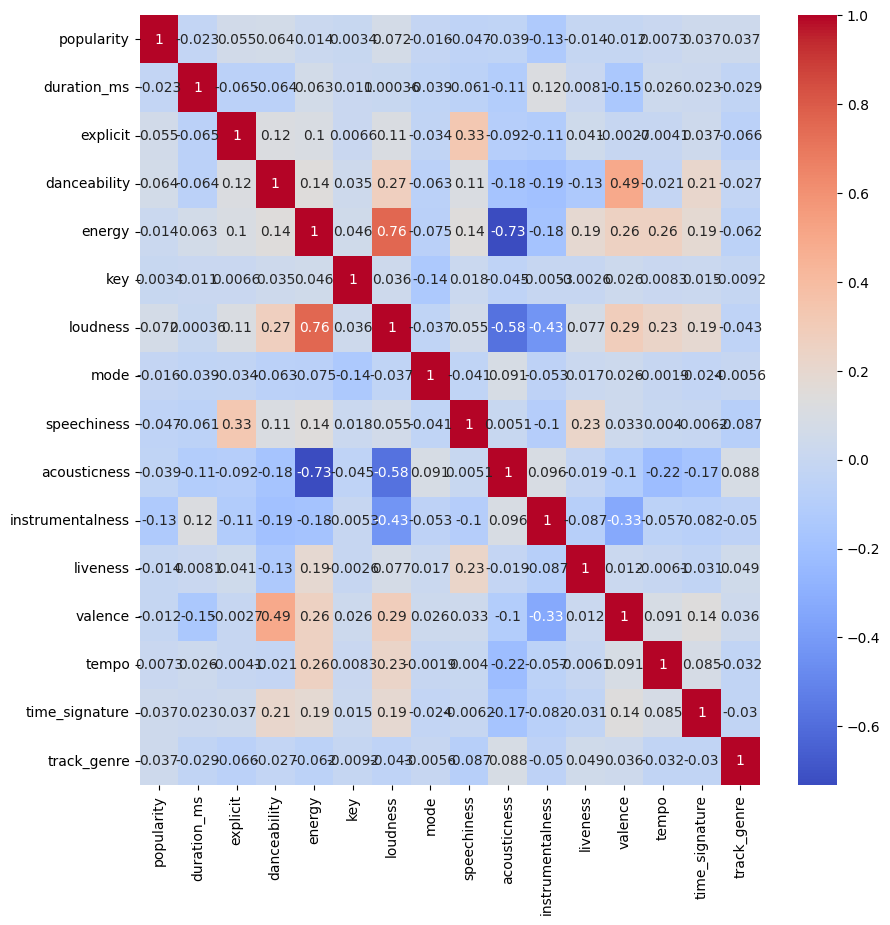

In [10]:
# Look at linear correlations between features
corr_matrix = revised_df.corr(method='pearson')
plt.figure(figsize=(10 , 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


In [5]:
np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(revised_df['loudness'], revised_df['energy'], test_size=0.2)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(71792,)
(71792,)
(17948,)
(17948,)


(-5.0, 3.0)

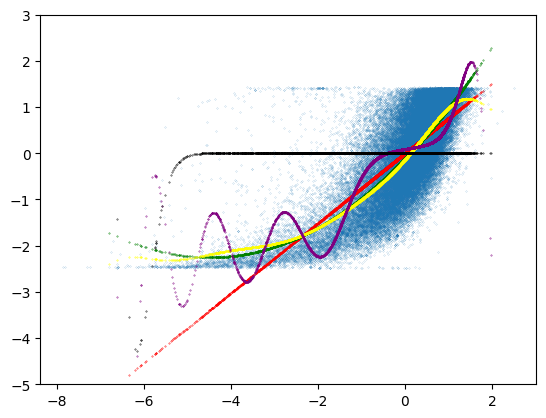

In [6]:
poly1 = PolynomialFeatures(degree=1, include_bias=False)
poly_reg_model = LinearRegression()
poly_features_1 = poly1.fit_transform(x_train.to_numpy().reshape(-1,1))
poly_features_test_1 = poly1.fit_transform(x_test.to_numpy().reshape(-1,1))
poly_reg_model.fit(poly_features_1, y_train)
energy_predicted_1 = poly_reg_model.predict(poly_features_test_1)
energy_predicted_train_1 = poly_reg_model.predict(poly_features_1)
plt.scatter(x_train, y_train, s=0.01)
plt.scatter(x_test, energy_predicted_1, s=0.1, c='red')

poly2 = PolynomialFeatures(degree=3, include_bias=False)
poly_features_2 = poly2.fit_transform(x_train.to_numpy().reshape(-1,1))
poly_features_test_2 = poly2.fit_transform(x_test.to_numpy().reshape(-1,1))
poly_reg_model.fit(poly_features_2, y_train)
energy_predicted_2 = poly_reg_model.predict(poly_features_test_2)
energy_predicted_train_2 = poly_reg_model.predict(poly_features_2)
plt.scatter(x_test, energy_predicted_2, s=0.1, c='green')

poly3 = PolynomialFeatures(degree=10, include_bias=False)
poly_features_3 = poly3.fit_transform(x_train.to_numpy().reshape(-1,1))
poly_features_test_3 = poly3.fit_transform(x_test.to_numpy().reshape(-1,1))
poly_reg_model.fit(poly_features_3, y_train)
energy_predicted_3 = poly_reg_model.predict(poly_features_test_3)
energy_predicted_train_3 = poly_reg_model.predict(poly_features_3)
plt.scatter(x_test, energy_predicted_3, s=0.1, c='yellow')

poly4 = PolynomialFeatures(degree=20, include_bias=False)
poly_features_4 = poly4.fit_transform(x_train.to_numpy().reshape(-1,1))
poly_features_test_4 = poly4.fit_transform(x_test.to_numpy().reshape(-1,1))
poly_reg_model.fit(poly_features_4, y_train)
energy_predicted_4 = poly_reg_model.predict(poly_features_test_4)
energy_predicted_train_4 = poly_reg_model.predict(poly_features_4)
plt.scatter(x_test, energy_predicted_4, s=0.1, c='purple')

poly5 = PolynomialFeatures(degree=50, include_bias=False)
poly_features_5 = poly5.fit_transform(x_train.to_numpy().reshape(-1,1))
poly_features_test_5 = poly5.fit_transform(x_test.to_numpy().reshape(-1,1))
poly_reg_model.fit(poly_features_5, y_train)
energy_predicted_5 = poly_reg_model.predict(poly_features_test_5)
energy_predicted_train_5 = poly_reg_model.predict(poly_features_5)
plt.scatter(x_test, energy_predicted_5, s=0.1, c='black')
plt.ylim(-5,3)

(-10.0, 5.0)

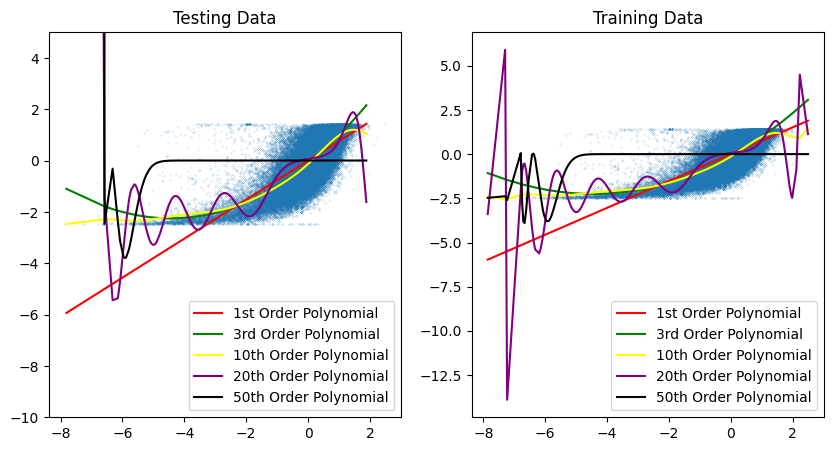

In [8]:
np.random.seed(1000)

x_train = y_train = y_test = x_test = poly_reg_model = sorted_train_indices = sorted_test_indices = regression_data = poly = poly_features_train = poly_features_test = fig = ax = energy_predicted_test = energy_predicted_train = None
x_train, x_test, y_train, y_test = train_test_split(revised_df['loudness'], revised_df['energy'], test_size=0.2)

polynomial_orders = [(1, "1st"), (3, "3rd"), (10, "10th"), (20, "20th"), (50, "50th")]
colors = ['red', 'green', 'yellow', 'purple', 'black']
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(x_train, y_train, s=0.01)
ax[1].scatter(x_train, y_train, s=0.01)

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()


sorted_train_indices = np.argsort(x_train)
sorted_test_indices = np.argsort(x_test)
x_train = x_train[sorted_train_indices]
x_test = x_test[sorted_test_indices]
y_train = y_train[sorted_train_indices]
y_test = y_test[sorted_test_indices]

poly_reg_model = LinearRegression()


regression_data = []
"""
poly1 = PolynomialFeatures(degree=1, include_bias=False)
poly_reg_model = LinearRegression()
poly_features_1 = poly1.fit_transform(x_train.to_numpy().reshape(-1,1))
poly_features_test_1 = poly1.fit_transform(x_test.to_numpy().reshape(-1,1))
poly_reg_model.fit(poly_features_1, y_train)
energy_predicted_1 = poly_reg_model.predict(poly_features_test_1)
energy_predicted_train_1 = poly_reg_model.predict(poly_features_1)
plt.scatter(x_train, y_train, s=0.01)
plt.scatter(x_test, energy_predicted_1, s=0.1, c='red')"""

for ind,i in enumerate(polynomial_orders):
    poly = PolynomialFeatures(degree=i[0], include_bias=False)
    poly_features_train = poly.fit_transform(x_train.reshape(-1,1))
    poly_features_test = poly.fit_transform(x_test.reshape(-1,1))
    poly_reg_model.fit(poly_features_train, y_train)

    energy_predicted_test = poly_reg_model.predict(poly_features_test)
    energy_predicted_train = poly_reg_model.predict(poly_features_train)

    ax[0].plot(x_test, energy_predicted_test, c=colors[ind], label=f"{i[1]} Order Polynomial")
    ax[1].plot(x_train, energy_predicted_train, c=colors[ind], label=f"{i[1]} Order Polynomial")
    regression_data.append([i,energy_predicted_train, energy_predicted_test])

# Both graphs have a scatterplot of the training data underneath the regression curves
ax[0].legend()
ax[1].legend()
ax[0].set_title("Testing Data")
ax[1].set_title("Training Data")
ax[0].set_ylim(-10,5)

In [7]:
poly_reg_rmse_train_1 = np.sqrt(mean_squared_error(y_train,energy_predicted_train_1))
poly_reg_rmse_test_1 = np.sqrt(mean_squared_error(y_test,energy_predicted_1))
print(poly_reg_rmse_test_1, poly_reg_rmse_train_1)


poly_reg_rmse_train_2 = np.sqrt(mean_squared_error(y_train,energy_predicted_train_2))
poly_reg_rmse_test_2 = np.sqrt(mean_squared_error(y_test,energy_predicted_2))
print(poly_reg_rmse_test_2, poly_reg_rmse_train_2)

poly_reg_rmse_train_3 = np.sqrt(mean_squared_error(y_train,energy_predicted_train_3))
poly_reg_rmse_test_3 = np.sqrt(mean_squared_error(y_test,energy_predicted_3))
print(poly_reg_rmse_test_3, poly_reg_rmse_train_3)

poly_reg_rmse_train_4 = np.sqrt(mean_squared_error(y_train,energy_predicted_train_4))
poly_reg_rmse_test_4 = np.sqrt(mean_squared_error(y_test,energy_predicted_4))
print(poly_reg_rmse_test_4, poly_reg_rmse_train_4)

poly_reg_rmse_train_5 = np.sqrt(mean_squared_error(y_train,energy_predicted_train_5))
poly_reg_rmse_test_5 = np.sqrt(mean_squared_error(y_test,energy_predicted_5))
print(poly_reg_rmse_test_5, poly_reg_rmse_train_5)

0.6552860702083613 0.6503717101423796
0.6184700206151316 0.6143012827023228
0.6158650935716686 0.611342502287401
0.724862119769776 0.717835144649512
0.9963143788012273 0.9970156423343309


In [9]:
for data in regression_data:
    rmse_train = np.sqrt(mean_squared_error(y_train, data[1]))
    rmse_test = np.sqrt(mean_squared_error(y_test, data[2]))
    print(f"{data[0][1]} Order Polynomial:")
    print(f"    RMSE for Training Data: {rmse_train}")
    print(f"    RMSE for Testing Data: {rmse_test}")
rmse_train = rmse_test = regression_data = None

1st Order Polynomial:
    RMSE for Training Data: 0.6515607320666389
    RMSE for Testing Data: 0.6505317330994379
3rd Order Polynomial:
    RMSE for Training Data: 0.6150049906076769
    RMSE for Testing Data: 0.6156649809737509
10th Order Polynomial:
    RMSE for Training Data: 0.6121803280236077
    RMSE for Testing Data: 0.6125447572084198
20th Order Polynomial:
    RMSE for Training Data: 0.7005068005571438
    RMSE for Testing Data: 2.346577401422845
50th Order Polynomial:
    RMSE for Training Data: 0.9968788752777263
    RMSE for Testing Data: 220.89590342071426
